In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
import nltk

In [ ]:
data = pd.read_csv('youtube_comments_cleaned.csv')
data.head()

,CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID
0,UgyRjrEdJIPrf68uND14AaABAg,mcY4M9gjtsI,They killed my friend.#tales #movie #shorts,@OneWhoWandered,UC_-UEXaBL1dqqUPGkDll49A,Anyone know what movie this is?,Neutral,0,2,2025-01-15 00:54:55,NZ,1
1,UgxXxEIySAwnMNw8D7N4AaABAg,2vuXcw9SZbA,Man Utd conceding first penalty at home in yea...,@chiefvon3068,UCZ1LcZESjYqzaQRhjdZJFwg,The fact they're holding each other back while...,Positive,0,0,2025-01-13 23:51:46,AU,17
2,UgxB0jh2Ur41mcXr5IB4AaABAg,papg2tsoFzg,Welcome to Javascript Course,@Abdulla-ip8qr,UCWBK35w5Swy1iF5xIbEyw3A,waiting next video will be?,Neutral,1,0,2020-07-06 13:18:16,IN,27
3,UgwMOh95MfK0GuXLLrF4AaABAg,31KTdfRH6nY,Building web applications in Java with Spring ...,@finnianthehuman,UCwQ2Z03nOcMxWozBb_Cv66w,Thanks for the great video.\n\nI don't underst...,Neutral,0,1,2024-09-18 12:04:12,US,27
4,UgxJuUe5ysG8OSbABAl4AaABAg,-hV6aeyPHPA,After a new engine her car dies on her way hom...,@ryoutubeplaylistb6137,UCTTcJ0tsAKQokmHB2qVb1qQ,Good person helping good people.\nThis is how ...,Positive,3,1,2025-01-10 19:39:03,US,2


In [ ]:
data = data[["CommentText", "Sentiment"]]
label_map = {"Negative": 0, "Positive": 1, "Neutral": 2}
rev_map = {1: "Positive", 0: "Negative", 2: "Neutral"}
data["Sentiment"] = data["Sentiment"].map(label_map)
data.head()

,CommentText,Sentiment
0,Anyone know what movie this is?,2
1,The fact they're holding each other back while...,1
2,waiting next video will be?,2
3,Thanks for the great video.\n\nI don't underst...,2
4,Good person helping good people.\nThis is how ...,1


In [ ]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
        text = text.lower()
        text = re.sub(r"http\S+", "", text)
        text = re.sub(r"@\S+", "", text)
        text = text.translate(str.maketrans("", "", string.punctuation))
        text = text.replace("\n", " ")
        text = re.sub(r"\s+", " ", text).strip()

    else:
        text = ""
    return text


data["cleaned_comment"] = data["CommentText"].apply(clean_text)
print(data[["CommentText", "cleaned_comment"]].head())

                                         CommentText  \
0                    Anyone know what movie this is?   
1  The fact they're holding each other back while...   
2                        waiting next video will be?   
3  Thanks for the great video.\n\nI don't underst...   
4  Good person helping good people.\nThis is how ...   

                                     cleaned_comment  
0                     anyone know what movie this is  
1  the fact theyre holding each other back while ...  
2                         waiting next video will be  
3  thanks for the great video i dont understand w...  
4  good person helping good people this is how it...  


In [ ]:
data = data.drop("CommentText", axis=1)
data = data.dropna()
data.head()

,Sentiment,cleaned_comment
0,2,anyone know what movie this is
1,1,the fact theyre holding each other back while ...
2,2,waiting next video will be
3,2,thanks for the great video i dont understand w...
4,1,good person helping good people this is how it...


In [ ]:
texts = data["cleaned_comment"].astype(str).tolist()
labels = data["Sentiment"].tolist()

tokenized_texts = [text.lower().split() for text in texts]
vocab = Counter(word for sent in tokenized_texts for word in sent)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(vocab.most_common(5000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1


def encode(seq):
    enc =  [vocab.get(word, vocab["<UNK>"]) for word in seq]
    return enc[:100]


encoded_texts = [torch.tensor(encode(seq)) for seq in tokenized_texts]
padded_texts = pad_sequence(encoded_texts, batch_first=True, padding_value=0)
labels_tensor = torch.tensor(labels)

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    padded_texts, labels_tensor, test_size=0.2, stratify=labels, random_state=42
)


# Dataset and DataLoader
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
train_loader = DataLoader(TextDataset(X_train, y_train), batch_size=256, shuffle=True)
test_loader = DataLoader(TextDataset(X_test, y_test), batch_size=256)

In [ ]:
class FeedforwardNet(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc1 = nn.Linear(embed_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.embedding(x).mean(dim=1)  # global average
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedforwardNet(len(vocab), 64, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_acc, val_acc = [], []

In [ ]:
for epoch in range(10):
    model.train()
    all_preds, all_labels = [], []
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    train_acc.append(acc)

    # Validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)
            all_preds.extend(out.argmax(1).cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    val_acc.append(accuracy_score(all_labels, all_preds))
    print(
        f"Epoch {epoch+1} - Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}"
    )

Epoch 1 - Train Acc: 0.6140, Val Acc: 0.6550
Epoch 2 - Train Acc: 0.6613, Val Acc: 0.6627
Epoch 3 - Train Acc: 0.6661, Val Acc: 0.6648
Epoch 4 - Train Acc: 0.6686, Val Acc: 0.6654
Epoch 5 - Train Acc: 0.6702, Val Acc: 0.6665
Epoch 6 - Train Acc: 0.6721, Val Acc: 0.6682
Epoch 7 - Train Acc: 0.6734, Val Acc: 0.6690
Epoch 8 - Train Acc: 0.6752, Val Acc: 0.6698
Epoch 9 - Train Acc: 0.6764, Val Acc: 0.6706
Epoch 10 - Train Acc: 0.6779, Val Acc: 0.6706


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
print(f"Precision score: {precision_score(all_labels, all_preds, average='macro')}")
print(f"Recall score: {recall_score(all_labels, all_preds, average = 'macro')}")
print(f"F1 score: {f1_score(all_labels, all_preds, average = 'macro')}")


Precision score: 0.6788086268832284
Recall score: 0.6705394591752337
F1 score: 0.6720752402574247


In [ ]:
accs = [0.6706, 0.6863]
precs = [0.6788, 0.6913]
recs = [0.6705, 0.6862]
f1s = [0.6720, 0.6876]

vecs = [accs, precs, recs, f1s]

names = ["FNN", "LSTM"]
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
accuracy_vec = {}
precision_vec = {}
recall_vec = {}
f1_score_vec = {}


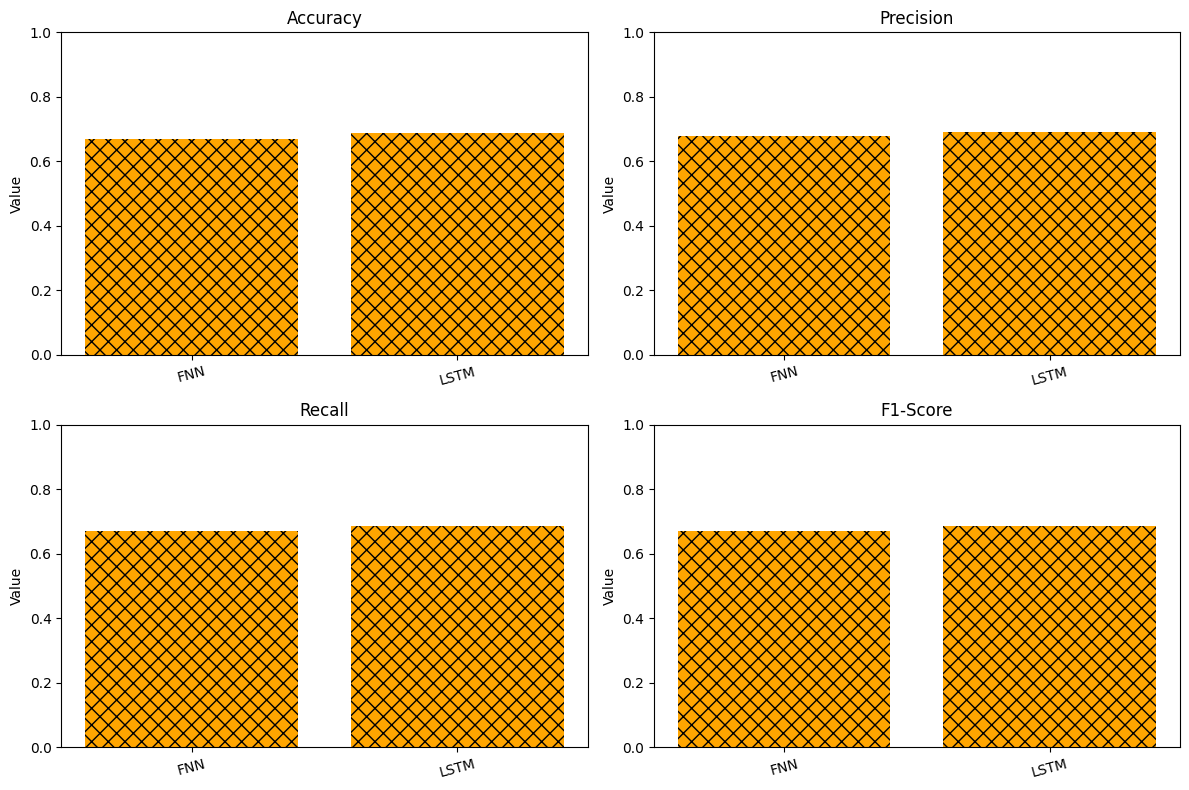

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.bar(names, vecs[i], color="orange", hatch="xx")
    plt.title(f"Model {metrics[i]} comparison")
    plt.title(metrics[i])
    plt.ylim(0, 1)
    plt.xticks(rotation=15)
    plt.ylabel("Value")

plt.tight_layout()
plt.show()